## NOTE: this is for demo purposes ONLY. 
The implementation takes liberties with both value sets AND logic, so do NOT assume this is "correct". We're mainly using this to show data prep

## OBJECTIVE: Implement the Northwestern Type 2 Diabetes Mellitus phenotype
### LOGIC SOURCE: 
           https://phekb.org/phenotype/type-2-diabetes-mellitus
### PATIENT DATA SOURCE: 
           We used Synthea(https://github.com/synthetichealth/synthea)
           to generate 1,000 synethic patients
### WARNING: The implementation information is no longer available online
           The site (NU VAULT) which housed it was retired. We obtained the implementation
           PDF and extracted the relevant value sets MANUALLY
           We then added additional codes where required based on our source data (from Synthea)
           as Synthea uses SNOMED CT for condition information whereas the supplied phenotype
           uses ICD-9 (it's from 2012). Given that, we also then had to MAP between ICD-9
           and SNOMED CT using UMLS.



In [31]:
import random
import numpy
import pandas

## Load Main Term List

In [32]:
#load our terms list (again)
term_list = pandas.read_csv(
        'phenotype/algorithm_term_list.csv'
        , dtype={'code': str}
        )

## Load and Clean Up Our (Mapped) DX Term List

In [33]:
#load our curated dx code list
#these are the codes produced by the prior step - the dx terms produced via the UMLS ICD-9 to SNOMED CT map
dx_1_dm_type_1 = pandas.read_csv(
        'phenotype/generated/terms_dx_1_dm_type_1.csv'
        , dtype={'SNOMED_CID': str}
        )
dx_1_dm_type_2 = pandas.read_csv(
        'phenotype/generated/terms_dx_1_dm_type_2.csv'
        , dtype={'SNOMED_CID': str}
        )
dx_8_dm = pandas.read_csv(
        'phenotype/generated/terms_dx_8_dm.csv'
        , dtype={'SNOMED_CID': str}
        )

#we no longer need our ICD codes, so let's clear those out
dx_1_dm_type_1 = dx_1_dm_type_1.drop(['ICD_CODE'], axis=1)
dx_1_dm_type_2 = dx_1_dm_type_2.drop(['ICD_CODE'], axis=1)
dx_8_dm = dx_8_dm.drop(['ICD_CODE'], axis=1)

#add our known SNOMED customizations
dx_1_dm_1_snomed = term_list[(term_list['algorithm'] == '1') & (term_list['domain'] =='dx' ) & (term_list['group'] =='dm_type_1' ) & (term_list['code_system'] =='SNOMED CT' ) & (term_list['include'] ==1 )]
dx_1_dm_1_snomed = dx_1_dm_1_snomed.drop(['algorithm', 'domain', 'group', 'term', 'code_system', 'include', 'exclude', 'source'], axis=1)
dx_1_dm_1_snomed = dx_1_dm_1_snomed.rename(index=str, columns={"code": "SNOMED_CID"})

dx_1_dm_2_snomed = term_list[(term_list['algorithm'] == '1') & (term_list['domain'] =='dx' ) & (term_list['group'] =='dm_type_2' ) & (term_list['code_system'] =='SNOMED CT' ) & (term_list['include'] ==1 )]
dx_1_dm_2_snomed = dx_1_dm_2_snomed.drop(['algorithm', 'domain', 'group', 'term', 'code_system', 'include', 'exclude', 'source'], axis=1)
dx_1_dm_2_snomed = dx_1_dm_2_snomed.rename(index=str, columns={"code": "SNOMED_CID"})

dx_8_dm_2_snomed = term_list[(term_list['algorithm'] == '8') & (term_list['domain'] =='dx' ) & (term_list['group'] =='dm' ) & (term_list['code_system'] =='SNOMED CT' ) & (term_list['include'] ==1 )]
dx_8_dm_2_snomed = dx_8_dm_2_snomed.drop(['algorithm', 'domain', 'group', 'term', 'code_system', 'include', 'exclude', 'source'], axis=1)
dx_8_dm_2_snomed = dx_8_dm_2_snomed.rename(index=str, columns={"code": "SNOMED_CID"})

#now add those custom codes to our existing mapped term list
dx_1_dm_type_1 = dx_1_dm_type_1.append(dx_1_dm_1_snomed)
dx_1_dm_type_1 = dx_1_dm_type_1.drop_duplicates()

dx_1_dm_type_2 = dx_1_dm_type_2.append(dx_1_dm_2_snomed)
dx_1_dm_type_2 = dx_1_dm_type_2.drop_duplicates()

dx_8_dm = dx_8_dm.append(dx_8_dm_2_snomed)
dx_8_dm = dx_8_dm.drop_duplicates()

## Patient Diagnoses (Conditions)

In [34]:
# Now that we have a dx code lists, let's check out the patient data
# we're going to load our patient data and then cross-check the supplied dx info from the patient
# against the term map, then again against the list of valid dx buckets
# we're then going to record our three columns of 1/0 indicators per patient
# There are many other (better) ways to approach this, but we're going to shortcut a bit by
# simply annotating "yes, in matching list" for each of the dx groups (algorithm 1 type 1, algorithm 2 type 2, algorithm 8)
# column list: START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION
# "CODE" represents the SNOMED CT concept
pt_dx = pandas.read_csv(
        'patient_data/conditions.csv'
        , parse_dates=['START', 'STOP']
        , dtype={'CODE': str}
        )

#now, let's go through the patient dx and annotate "found in set" for the appropriate dx groups
# there are two different ways these can be assigned
# 1) create a new column (example below)
#   NOTE: in this case you would NOT pre-create the column in the destination data frame
#   pt_dx = pt_dx.assign(dx_1_type_1_dm=pt_dx.CODE.isin(dx_1_dm_type_1.SNOMED_CID).astype(str))
# 2) explicitly create a column and set the value to true/false
#   we're going to use that example
#   we're going to add some empty "indicator" columns to our patient dx data so it's
#   it's explicit that we're doing it (again - example)
pt_dx['dx_1_type_1_dm'] = numpy.nan
pt_dx['dx_1_type_2_dm'] = numpy.nan
pt_dx['dx_8_dm'] = numpy.nan

pt_dx['dx_1_type_1_dm'] = pt_dx['CODE'].isin(dx_1_dm_type_1['SNOMED_CID']).astype(str)
pt_dx['dx_1_type_2_dm'] = pt_dx['CODE'].isin(dx_1_dm_type_2['SNOMED_CID']).astype(str)
pt_dx['dx_8_dm'] = pt_dx['CODE'].isin(dx_8_dm['SNOMED_CID']).astype(str)

pt_dx.to_csv('adjusted_patient_data/conditions_with_dm_annotations.csv', sep=',')

# you can visually validate with
# print pt_dx[(pt_dx['dx_1_type_2_dm']=='True')] #NOTE: probably no records here
# print pt_dx[(pt_dx['dx_1_type_2_dm']=='True')] #should be some
# print pt_dx[(pt_dx['dx_8_dm']=='True')]		 #we forced some SNOMED terms in here

### DX1 - Type 1 DM

False    9069
Name: dx_1_type_1_dm, dtype: int64


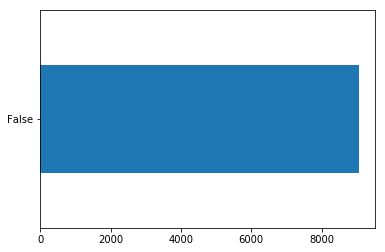

In [35]:
print pt_dx['dx_1_type_1_dm'].value_counts()
pt_dx['dx_1_type_1_dm'].value_counts().plot(kind='barh');

### DX1 - Type 2 DM

False    8897
True      172
Name: dx_1_type_2_dm, dtype: int64


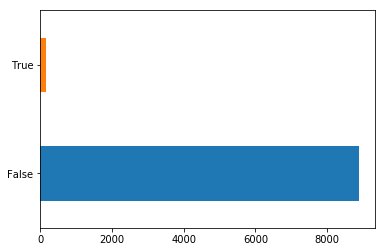

In [36]:
print pt_dx['dx_1_type_2_dm'].value_counts()
pt_dx['dx_1_type_2_dm'].value_counts().plot(kind='barh');

### DX8 - Any DM

False    8981
True       88
Name: dx_8_dm, dtype: int64


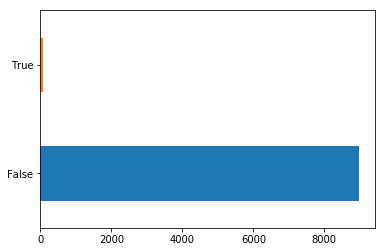

In [37]:
print pt_dx['dx_8_dm'].value_counts()
pt_dx['dx_8_dm'].value_counts().plot(kind='barh');

## Meds

In [38]:
# load the patient meds
pt_med = pandas.read_csv(
        'patient_data/medications.csv'
        , parse_dates=['START', 'STOP']
        , dtype={'CODE': str}
        )

# Now let's do meds - which should be easier because we don't need to map terms - everything is RxNorm
meds_type_1_dm = term_list[(term_list['algorithm'] == '*') & (term_list['domain'] =='med' ) & (term_list['group'] =='dm_type_1' ) & (term_list['code_system'] =='RxNorm' ) & (term_list['include'] ==1 )]
meds_type_2_dm = term_list[(term_list['algorithm'] == '*') & (term_list['domain'] =='med' ) & (term_list['group'] =='dm_type_2' ) & (term_list['code_system'] =='RxNorm' ) & (term_list['include'] ==1 )]
meds_8_supply_dm = term_list[(term_list['algorithm'] == '8') & (term_list['domain'] =='supply' ) & (term_list['group'] =='dm' ) & (term_list['code_system'] =='RxNorm' ) & (term_list['include'] ==1 )]

#print meds_type_1_dm
#print meds_type_2_dm

pt_med['med_type_1_dm'] = numpy.nan
pt_med['med_type_2_dm'] = numpy.nan
pt_med['med_8_supply_dm'] = numpy.nan

pt_med['med_type_1_dm'] = pt_med['CODE'].isin(meds_type_1_dm['code']).astype(str)
pt_med['med_type_2_dm'] = pt_med['CODE'].isin(meds_type_2_dm['code']).astype(str)
pt_med['med_8_supply_dm'] = pt_med['CODE'].isin(meds_8_supply_dm['code']).astype(str)

# visual validation if you need to
#print pt_med[(pt_med['med_type_1_dm']=='True')]
#print pt_med[(pt_med['med_type_2_dm']=='True')]
#print pt_med[(pt_med['med_8_supply_dm']=='True')] #you're not likely to get matches from our data - we don't have supplies

pt_med.to_csv('adjusted_patient_data/medication_with_dm_annotations.csv', sep=',')

## Labs

In [39]:
# load the labs - larger file
pt_lab = pandas.read_csv(
        'patient_data/observations.csv'
        , parse_dates=['DATE']
        , dtype={'CODE': str}
        )

# again, labs should be easier to code becuase we're using Loinc in both sets
lab_dm = term_list[(term_list['algorithm'] == '*') & (term_list['domain'] =='lab' ) & (term_list['group'] =='dm' ) & (term_list['code_system'] =='LOINC' ) & (term_list['include'] ==1 )]

pt_lab['lab_dm'] = numpy.nan
pt_lab['lab_dm_abnormal'] = numpy.nan

pt_lab['lab_dm'] = pt_lab['CODE'].isin(lab_dm['code']).astype(str)

# visual validations
#print pt_lab[(pt_lab['lab_dm']=='True')]

# if lab :type == random-glucose
# 	and lab :value >= 110 // (mg/dl)
# or lab :type == fasting-glucose
# 	and lab :value >= 110 // (mg/dl)
# or lab :type == HBA1c
# 	and lab :value >= 6.0 // (percent)

# this is a bad approach, but this is JUST for demo purposes, so we're going to simplify
# we're going to filter the list to those labs where we have a glucose reading (pt_lab['lab_dm'] == 'True')
# and where we get a specific value comparison for a particular unit type
# >= 110.0	mg/dL
# >= 6.0	%

#in this case we're going to use a closure example
def lab_abnormal(lab):
    if lab['lab_dm'] == 'True':
        if lab['UNITS'] == '%' and lab['TYPE'] == 'numeric' and float(lab['VALUE']) >= 6.0:
            return 'True'
        elif lab['UNITS'] == 'mg/dL' and lab['TYPE'] == 'numeric' and float(lab['VALUE']) >= 110.0:
            return 'True'
        else:
            return 'False'
    else:
        return 'False'

pt_lab['lab_dm_abnormal'] = pt_lab.apply(lab_abnormal, axis=1)

pt_lab.to_csv('adjusted_patient_data/observations_with_dm_annotations.csv', sep=',')

### Lab - DM Lab Abnormal

False    247178
True       3462
Name: lab_dm_abnormal, dtype: int64


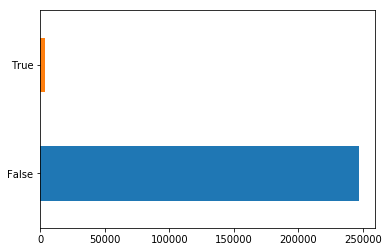

In [40]:
print pt_lab['lab_dm_abnormal'].value_counts()
pt_lab['lab_dm_abnormal'].value_counts().plot(kind='barh');

## Patients - Annotate with Indicators

### Load Patient Data

In [41]:
#Let's load the patients and annotate the findings we need for computing things later
pt = pandas.read_csv(
        'patient_data/patients.csv'
        , parse_dates=['BIRTHDATE','DEATHDATE']
        )

### Append DX Indicators

In [42]:
#Count of distinct dates of T1DM DX
t1dm_dx = pt_dx[pt_dx['dx_1_type_1_dm'] == 'True'].groupby('PATIENT').agg({'START':{'t1dm_dx_count':pandas.Series.nunique}})
t1dm_dx.columns = t1dm_dx.columns.droplevel(0)
pt = pt.merge(t1dm_dx, left_on='Id', right_on='PATIENT', how='left')
pt[['t1dm_dx_count']] = pt[['t1dm_dx_count']].fillna(value=0)

#Count of distinct dates of T2DM DX
t2dm_dx = pt_dx[pt_dx['dx_1_type_2_dm'] == 'True'].groupby('PATIENT').agg({'START':{'t2dm_dx_count':pandas.Series.nunique}})
t2dm_dx.columns = t2dm_dx.columns.droplevel(0)
pt = pt.merge(t2dm_dx, left_on='Id', right_on='PATIENT', how='left')
pt[['t2dm_dx_count']] = pt[['t2dm_dx_count']].fillna(value=0)

# Count of distinct dates of DM-related DX
dm_dx = pt_dx[pt_dx['dx_8_dm'] == 'True'].groupby('PATIENT').agg({'START':{'dm_dx_count':pandas.Series.nunique}})
dm_dx.columns = dm_dx.columns.droplevel(0)
pt = pt.merge(dm_dx, left_on='Id', right_on='PATIENT', how='left')
pt[['dm_dx_count']] = pt[['dm_dx_count']].fillna(value=0)

### Append Med Indicators

In [43]:
# First date of Rx for T2DM medication
t2dm_med_first = pt_med[pt_med['med_type_2_dm'] == 'True'].groupby('PATIENT')['START'].agg({'START':{'t2dm_med_first':'min'}})
t2dm_med_first.columns = t2dm_med_first.columns.droplevel(0)
pt = pt.merge(t2dm_med_first, left_on='Id', right_on='PATIENT', how='left')
pt[['t2dm_med_first']] = pt[['t2dm_med_first']].fillna(value=0)

# First date of Rx for T1DM medication
#t1dm_med = pt_med[pt_med['med_type_1_dm'] == 'True'].groupby('PATIENT')['START'].agg({'count':pandas.Series.nunique})
t1dm_med_first = pt_med[pt_med['med_type_2_dm'] == 'True'].groupby('PATIENT')['START'].agg({'START':{'t1dm_med_first':'min'}})
t1dm_med_first.columns = t1dm_med_first.columns.droplevel(0)
pt = pt.merge(t1dm_med_first, left_on='Id', right_on='PATIENT', how='left')
pt[['t1dm_med_first']] = pt[['t1dm_med_first']].fillna(value=0)

# Count DM-related medications and supplies by distinct Rx date
# for now - because we don't have med supplies - we're just going to use the dm med counts
pt_dm_meds = pt_med[(pt_med['med_type_2_dm'] == 'True')|(pt_med['med_type_1_dm'] == 'True')].groupby('PATIENT')['START'].agg({'PATIENT':{'dm_med_count':'count'}})
pt_dm_meds.columns = pt_dm_meds.columns.droplevel(0)
pt = pt.merge(pt_dm_meds, left_on='Id', right_on='PATIENT', how='left')
pt[['dm_med_count']] = pt[['dm_med_count']].fillna(value=0)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  app.launch_new_instance()


### Append Lab Indicators

In [44]:
# Check for glucose lab performed
pt['lab_dm'] = numpy.nan
pt_lab_dm = pt_lab[(pt_lab['lab_dm'] == 'True')]
pt['lab_dm'] = pt['Id'].isin(pt_lab_dm['PATIENT']).astype(str)
#visual validation
#print pt[(pt['lab_dm']=='True')] 

# Check for abnormal lab
pt_dx['lab_dm_abnormal'] = numpy.nan
lab_dm_abnormal = pt_lab[(pt_lab['lab_dm_abnormal'] == 'True')]
pt['lab_dm_abnormal'] = pt['Id'].isin(lab_dm_abnormal['PATIENT']).astype(str)

### Append Family History of Diabetes

False    1099
True      119
Name: diabtes_history, dtype: int64


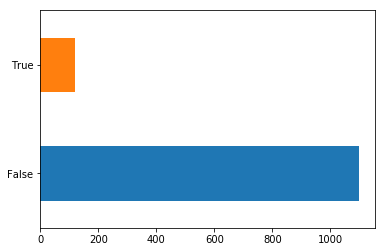

In [45]:
# Check for family history of DM
# We don't have this data, so we're just going to randomize this
diabetes_choices = [True, False]
diabetes_weights = [0.10, 0.90]
def random_diabetes_history(patient):
    return numpy.random.choice(diabetes_choices, p=diabetes_weights).astype(str)

pt['diabtes_history'] = pt.apply(random_diabetes_history, axis=1)

print pt['diabtes_history'].value_counts()
pt['diabtes_history'].value_counts().plot(kind='barh');

### Append Office Visit Count

In [46]:
#Count of distinct dates for in-person office encounters with a physician
# for this one we're cheating - all of our encounter types (right now) are face to face
# ENCOUNTERCLASS: ambulatory, emergency, inpatient, outpatient, urgentcare, wellness
pt_enc = pandas.read_csv(
        'patient_data/encounters.csv'
        , parse_dates=['START','STOP']
        )

enc_types = ['ambulatory', 'emergency', 'inpatient', 'outpatient', 'urgentcare', 'wellness']

enc_count = pt_enc[pt_enc['ENCOUNTERCLASS'].isin(enc_types)].groupby('PATIENT')['START'].agg({'PATIENT':{'enc_count':'count'}})
enc_count.columns = enc_count.columns.droplevel(0)
pt = pt.merge(enc_count, left_on='Id', right_on='PATIENT', how='left')
pt[['enc_count']] = pt[['enc_count']].fillna(value=0)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()


## Case / Control 
For reference, the columns we intend to use are...
* t1dm_dx_count
* t2dm_dx_count
* dm_dx_count
* t2dm_med_first 
* t1dm_med_first
* lab_dm
* lab_dm_abnormal
* dm_med_count   
* diabtes_history
* enc_count

## T2DM Control
* if dm-dx-dt-cnt(pt) == 0
* and glucose-lab-exists(pt) == true
* and abnormal-lab(pt) == false
* and enctrs-dt-cnt(pt) >= 2
* and dm-meds-supplies-rx-dt-cnt(pt) == 0
* and fam-hist-of-dm(pt) == false

In [47]:
######### Set up our control indicators
pt['pt_dm_control'] = numpy.nan
def pt_dm_control_check(pt):
    if (
    	(pt['dm_dx_count'] == 0) and
        (pt['lab_dm'] =='True' ) and 
        (pt['lab_dm_abnormal'] =='False' ) and 
        (pt['enc_count'] >=2 ) and 
        (pt['dm_med_count'] ==0 ) and 
        (pt['diabtes_history'] == 'False' )
        ):
        return 'True'
    else:
        return 'False'

pt['pt_dm_control'] = pt.apply(pt_dm_control_check, axis=1)

False    1130
True       88
Name: pt_dm_control, dtype: int64


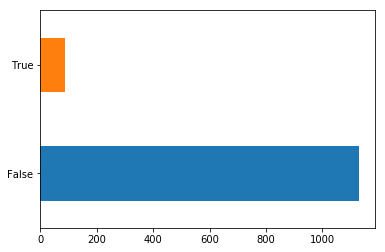

In [52]:
print pt['pt_dm_control'].value_counts()
pt['pt_dm_control'].value_counts().plot(kind='barh');

In [48]:
#if you want to output some validation
#print pt[(pt['dm_dx_count']==0)]
#print pt[(pt['lab_dm']=='True')]
#print pt[(pt['lab_dm_abnormal']=='False')]
#print pt[(pt['enc_count']>=2)]
#print pt[(pt['dm_med_count']>=0)].shape
#print pt[(pt['diabtes_history']=='False')].shape
#print pt[(pt['pt_dm_control']=='True')]

## T2DM Case

* t2dm-case-selection(pt)
  * status = unknown
  * 1 if 
    *     t1dm-dx-dt-cnt(pt) == 0 ( Algorithm 2
    *     and t2dm-dx-dt-cnt(pt) > 0 ( Algorithm 3
    *     and t2dm-rx-dt(pt) != null ( Algorithm 4
    *     and t1dm-rx-dt(pt) != null ( Algorithm 5
    *     and t2dm-rx-dt(pt) < t1dm-rx-dt(pt)
      *   status = case
  * 2 elseif 
    *     t1dm-dx-dt-cnt(pt) == 0
    *     and t2dm-dx-dt-cnt(pt) > 0
    *     and t1dm-rx-dt(pt) == null
    *     and t2dm-rx-dt(pt) != null
      *   status = case
  * 3 elseif
    *     t1dm-dx-dt-cnt(pt) == 0
    *     and t2dm-dx-dt-cnt(pt) > 0
    *     and t1dm-rx-dt(pt) == null
    *     and t2dm-rx-dt(pt) == null
    *     and abnormal-lab(pt) == true ( Algorithm 6
      *   status = case
  * 4 elseif
    *     t1dm-dx-dt-cnt(pt) == 0
    *     and t2dm-dx-dt-cnt(pt) == 0
    *     and t2dm-rx-dt(pt) != null
    *     and abnormal-lab(pt) == true
      *   status = case
  * 5 elseif 
    *     t1dm-dx-dt-cnt(pt) == 0
    *     and t2dm-dx-dt-cnt(pt) > 0
    *     and t1dm-rx-dt(pt) != null
    *     and t2dm-rx-dt(pt) == null
    *     and t2dm-physcn-dx-dt-cnt(pt) >= 2 ( Algorithm 7
      *   status = case
  * (else false)

In [49]:
######### Set up our case indicators
pt['pt_dm_case'] = numpy.nan
def pt_dm_case_check(pt):
    if (
        pt['t1dm_dx_count'] == 0
        and pt['t2dm_dx_count'] > 0
        and pandas.notna(pt['t2dm_med_first'])# != null
        and pandas.notna(pt['t1dm_med_first'])# != null
        and pt['t2dm_med_first'] < pt['t1dm_med_first']
        ):
        return 'True'
    elif (
        pt['t1dm_dx_count'] == 0
        and pt['t2dm_dx_count'] > 0
        and pandas.isna(pt['t1dm_med_first'])# == null
        and notna(pt['t2dm_med_first'])# != null
        ):
        return 'True'
    elif (
        pt['t1dm_dx_count'] == 0
        and pt['t2dm_dx_count'] > 0
        and pandas.isna(pt['t1dm_med_first'])# == null
        and pandas.isna(pt['t2dm_med_first'])# == null
        and pt['lab_dm_abnormal'] == 'True'
        ):
        return 'True'
    elif (
        pt['t1dm_dx_count'] == 0
        and pt['t2dm_dx_count'] == 0
        and pandas.notna(pt['t2dm_med_first'])# != null
        and pt['lab_dm_abnormal'] == 'True'
        ):
        return 'True'
    elif (
        pt['t1dm_dx_count'] == 0
        and pt['t2dm_dx_count'] > 0
        and pandas.notna(pt['t1dm_med_first'])# != null
        and pandas.isna(pt['t2dm_med_first'])# == null
        and pt['t2dm_dx_count'] >= 2
        ):
        return 'True'
    else:
        return 'False'

pt['pt_dm_case'] = pt.apply(pt_dm_case_check, axis=1)

False    879
True     339
Name: pt_dm_case, dtype: int64


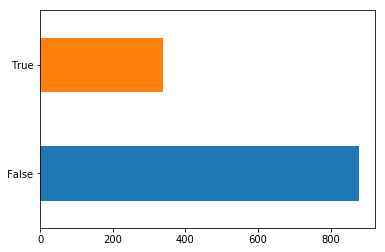

In [53]:
print pt['pt_dm_case'].value_counts()
pt['pt_dm_case'].value_counts().plot(kind='barh');

## Write Out The Patient Annotation File

In [50]:
### write out the patient
pt.to_csv('adjusted_patient_data/patient_with_dm_annotations.csv', sep=',')